# Application of an Semi-automated Delta Method for Stroubles Creek, Blacksburg, VA

This program models dissolved oxygen, primary production, and respiration for Stroubles Creek in Blacksburg, VA on the campus of Virginia Tech. Data is provided by the Learning Enhanced Watershed Assessment System (LEWAS). 

"LEWAS is a real-time water and weather monitoring system developed to enhance water sustainability eduacation and research at Virginia Tech... [it] has sensors to measure water quality and quantity data including flow rate, depth, pH, dissolved oxygen, conductivity, and temperature." (http://www.lewas.centers.vt.edu/) See figure below for more details. 

See https://en.wikipedia.org/wiki/Stroubles_Creek for additional information about Stroubles Creek. 

Author: Billy Raseman, Graduate Research Assistant at University of Colorado Boulder

In [1]:
# display LEWAS Lab schematic
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www.lewas.centers.vt.edu/images/FlowDiagramWIPv2presentations-02.jpg")

## Import libraries

In [2]:
import numpy as np     # fundamental scientific computing package
import pandas as pd    # data structures and data analysis tools 
import matplotlib.pyplot as plt  # 2D plotting library (MATLAB-like plotting framework)
from scipy.optimize import least_squares  # least-squares optimization
import datetime as dt  # for manipulating date and time data 
%matplotlib inline     

## Define function for saturated dissolved oxygen concentration

### Sample data from Stroubles Creek

In [7]:
temp_C = 10.43  # degrees Celcius
salinity = 0  # assume no salinity in river
elev = 0.634  # elevation of LEWAS station (km)

sat_dissolved_oxygen(temp_C, salinity, elev)

10.361188165026867

## Create timeseries of saturated dissolved oxygen 

### Import and visualize temperature and calculated saturated DO data from one day (2/9/17) of Stroubles Creek 

In [8]:
df_temp = pd.read_csv("lewas_data-temp.csv") 
df_temp['Time'] = pd.to_datetime(df_temp['Time'], format=' %I:%M:%S %p')  # convert to class datetime
del df_temp['Date']

In [9]:
df_temp['Saturated DO'] = "" # initialize empty array for 'for-loop'

In [10]:
# calculate saturated DO
df_temp['Saturated DO'] = "" # initialize empty array for 'for-loop'
salinity = 0  # assume no salinity in river
elev = 0.634  # elevation of Blacksburg, VA (km)

for i in range(0, len(df_temp)): 
    df_temp.loc[i, 'Saturated DO'] = sat_dissolved_oxygen(df_temp.loc[i, 'Water Temperature (deg C)'], salinity, elev)
    # for info on .loc, see: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy 

In [11]:
df_temp.head()  # show format of data 

,Time,Water Temperature (deg C),Saturated DO
0,1900-01-01 00:00:10,10.14,10.4319
1,1900-01-01 00:01:10,10.14,10.4319
2,1900-01-01 00:02:10,10.14,10.4319
3,1900-01-01 00:03:10,10.15,10.4295
4,1900-01-01 00:04:10,10.14,10.4319


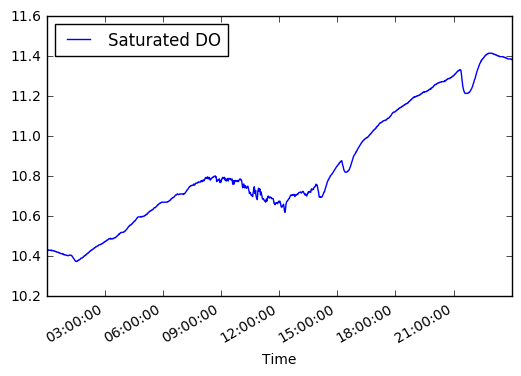

In [12]:
plt.figure; df_temp.plot(x='Time', y='Saturated DO')  # plot

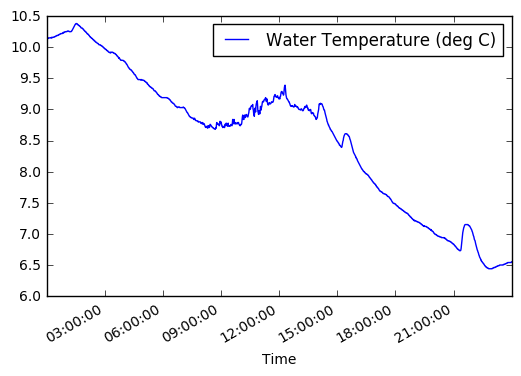

In [13]:
plt.figure; df_temp.plot(x='Time', y='Water Temperature (deg C)')  # plot

## Create time series for dissolved oxygen

### Import DO data from one day (5/2/14) of Stroubles Creek

In [14]:
df_DO = pd.read_csv("lewas_data-DO_2014-05-02.csv") 
df_DO['Time'] = pd.to_datetime(df_DO['Time'], format='%I:%M:%S %p')  # convert to class datetime
del df_DO['Date']

In [15]:
df_DO.head()

,Time,DO (mg/L)
0,1900-01-01 00:00:20,8.17
1,1900-01-01 00:05:20,8.14
2,1900-01-01 00:10:20,8.22
3,1900-01-01 00:15:20,8.23
4,1900-01-01 00:20:20,8.22


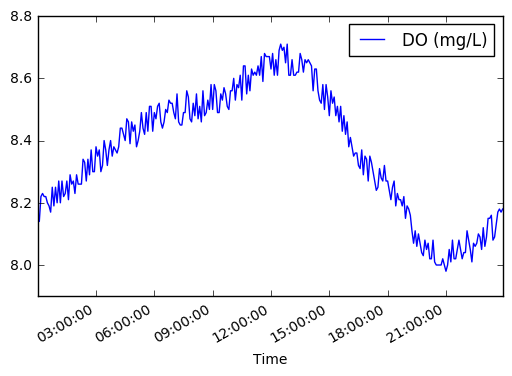

In [16]:
plt.figure; df_DO.plot(x='Time', y='DO (mg/L)')  # plot

## Photoperiod Data (2/9/17)

In [17]:
year = 2017
month = 2
day = 9

In [18]:
# photoperiod times (hours after midnight)
# data source: https://www.esrl.noaa.gov/gmd/grad/solcalc/
t_r = 7 + 17/60  # sunrise (HH:MM)
t_n = 12 + 54/60  # solar noon (HH:MM)
t_s = 17 + 55/60  # sunset (HH:MM)
f = t_s - t_r  # photoperiod (HH:MM)

## Fit DO Data to Sine Function

### Create sine function

In [19]:
def fun_sine(x, amp, period, phase, vert):
    
    """
    -------------------------------------------------------------------------------
    Purpose: A generalized sine function equation 
    Source: https://www.mathsisfun.com/algebra/amplitude-period-frequency-phase-shift.html
        
        y = A*sin(B*x + C) + D
            
            where:
            amplitude is A
            period is 2*pi/B
            phase shift is -C/B
            vertical shift is D
    
    -------------------------------------------------------------------------------
    
    Input: 
        x - array of x values 
        amp - amplitude      
        per - period 
        phase - phase shift (positive values shift right)
        vert - vertical shift (positive values shift up)
            
    Output
        y - array of resulting values from general sine function
             
    Author: Billy Raseman
    
    """   
    A = amp
    B = 2*np.pi/period
    C = -phase*B
    D = vert
    
    y = np.array(A*np.sin( B*x + C) + D)
    
    return y


In [20]:
amp = 0.3
period = 24
phase = 3
vert = 8.3
x = np.linspace(0, period, 100)
y = fun_sine(x, amp, period, phase, vert)

In [21]:
len(y)

100

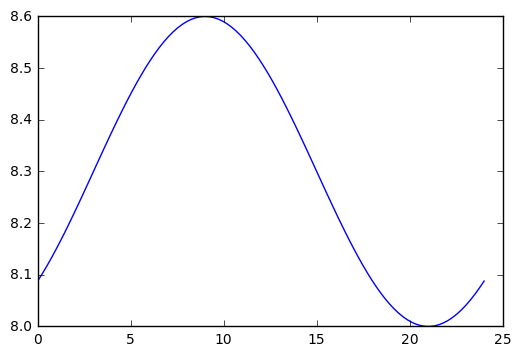

In [22]:
plt.plot(x,y)

### Fit DO data from 5/2/14 to sine function

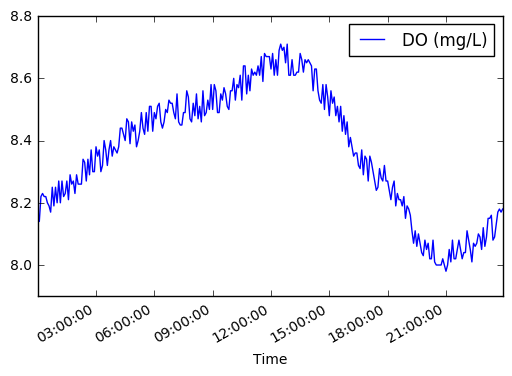

In [23]:
plt.figure; df_DO.plot(x='Time', y='DO (mg/L)')  # plot

Amplitude:  0.267425160795
Phase:  -1.14627014648
Mean:  8.36779057951


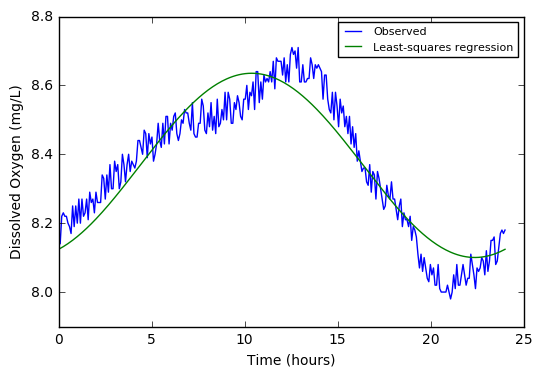

In [58]:
import numpy as np
from scipy.optimize import leastsq
import pylab as plt
# source: http://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy by Dhara. accessed: 5/1/17

# inputs for sine fitting
data = DO  # dissolved oxygen (mg/L)
period = 1  # assume only 1 period for one day
t = np.linspace(0, 2*np.pi*period, len(DO))

# guesses for three fitting parameters: mean, amplitude, and phase
guess_mean = np.mean(data)
guess_amp = 3*np.std(data)/(2**0.5)
guess_phase = 0

data_first_guess = guess_amp*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(t+x[1]) + x[2] - data
est_amp, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_phase, guess_mean])[0]

print("Amplitude: ", est_amp)
print("Phase: ", est_phase)
print("Mean: ", est_mean)


# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(t+est_phase) + est_mean

time = np.linspace(0, 24, len(data))
plt.plot(x, data, label='Observed')
plt.plot(x, data_fit, label='Least-squares regression')
plt.xlabel('Time (hours)')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend(prop={'size':8})
plt.show()

## Determine phi and delta from fitted sine curve

## Create numerical solution for the Fourier Series

In [62]:
# based on sinusoidal fitting, determine D_bar, delta, and phi
o_sat = df_temp['Saturated DO']
DO = df_DO['DO (mg/L)']
D_bar = np.mean(o_sat) - np.mean(data_fit)  # need to make this for the same day
delta = max(data_fit) - min(data_fit)
##phi = np.where(D==D.min())[0] - t_n  # based on eyeballing. automate this. 


array([ 741.5])

n: [1 2]
b_n: [ 0.51851626  0.18031708]
P_avg: 8.620892750810997


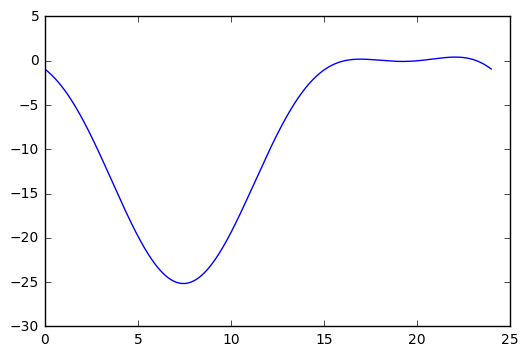

[745]
phi: [ 7.45]


In [63]:
import numpy as np
import matplotlib.pyplot as plt  # 2D plotting library (MATLAB-like plotting framework)

# model inputs
P_m = 25  # mg/L/d
T_p = 24  # daily period (hr)
f = 13  # photoperiod (hr)
R = 0  # respiration
k_a = 1  # aeration rate (1/d)
o_sat = 10  # oxygen saturation (mg/L)

# 2-term fourier series
time = np.arange(0, 24, 0.01)
n = np.arange(1, 3)
print("n:", n)
b_n = np.empty(len(n))  # fourier-series constant, eq. 24.28

for i in range(len(n)):
    b_n[i] = np.cos(n[i]*np.pi*f/T_p) * ( (4*np.pi*T_p/f) / ( (np.pi*T_p/f)**2 - (2*np.pi*n[i])**2) )

print("b_n:", b_n)

## primary production
P_sum = np.empty([len(n), len(time)])  # summation expression in eq. 24.27
for i in range(len(n)):
    for j in range(len(time)):
        P_sum[i, j] = b_n[i]*np.cos( 2*np.pi*n[i]/T_p * (time[j] - f/2))
        #P_sum[i, j] = b_n[i] * np.cos(2 * np.pi * n[i] / T_p * (time[j] - f / 2))

P = P_m*( 2*f/(np.pi*T_p) + np.sum(P_sum, axis = 0))
#plt.plot(time, P)
#plt.show()  # this is correct!

P_avg = P_m*(2*f/(np.pi*T_p))
print("P_avg:", P_avg)

## deficit
D_sum = np.empty([len(n), len(time)])  # summation expression in eq. 24.29
for i in range(len(n)):
    for j in range(len(time)):
        D_sum[i, j] = b_n[i] / np.sqrt( k_a**2 + (2*np.pi*n[i]/T_p)**2) * \
                      np.cos( 2*np.pi*n[i]/T_p * (time[j]-f/2) - np.arctan(2*np.pi*n[i] / (k_a*T_p)) )

    # for j in range(len(time)):
    #     D_sum[i, j] = b_n[i] / np.sqrt(k_a ** 2 + (2 * np.pi * n[i] / T_p) ** 2) * \
    #                   np.cos(2 * np.pi * n[i] / T_p * (time[j] - f / 2) - np.arctan(2 * np.pi * n[i] / (k_a * T_p)))
D_bar = (R - P_avg)/k_a
D = D_bar - P_m*np.sum(D_sum, axis = 0)
plt.plot(time, D)
plt.show()  # this is correct!

t_n = f/2  # solar noon (hours after sunrise)
t_min = np.where(D==D.min())[0]
print(t_min)
phi = time[t_min]
print("phi:", phi)  # THIS IS WRONG. IT IS ~7.5 and should be ~5

# plot(time, o, xlab="Time (hours after sunrise)", ylab="Dissolved oxygen (mg/L)", type='l')